# Generalized Quantum Fourier Transform Algorithm

In [5]:
import numpy as np
from numpy import pi
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [181]:
def qft_rotations(circ, n):
    """Converts input quantum state into fourier basis (missing swaps)"""
    if n == 0:
        return circ
    n -= 1
    circ.h(n)
    for qubit in range(n):
        circ.crz(pi/2**(n-qubit), qubit, n)
    # We just converted the first qubit. To convert the rest into fourier basis, we will run the same function repetitively.
    qft_rotations(circ, n)

In [215]:
def swap_registers(circ, n):
    """Swapping order of qubits to fix qiskit natural ordering upon measurement"""
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
    return circ

def qft_full(circ, n):
    """QFT on the first n qubits in circ"""
    qft_rotations(circ, n)
    swap_registers(circ, n)
    return circ

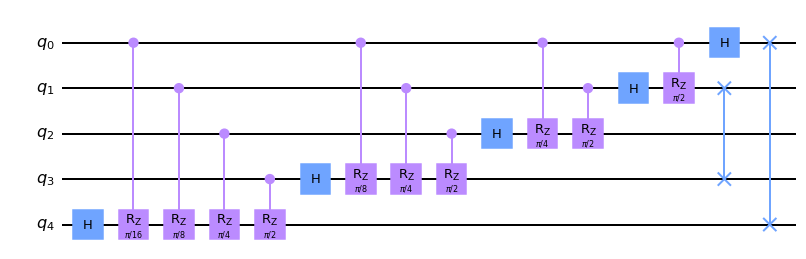

In [216]:
# Let's see how it looks:
circ = QuantumCircuit(5)
qft_full(circ,5)
circ.draw('mpl')

# Sample implementation + Running on a real QC

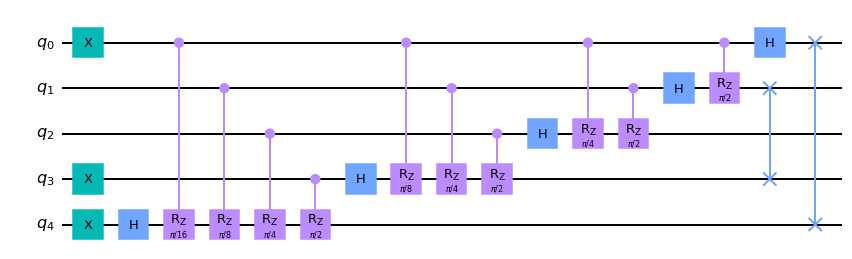

In [217]:
"""Let's convert the number 25 (11001)"""
circ = QuantumCircuit(5)
circ.x([0,3,4])
qft_full(circ, 5)
circ.draw('mpl')

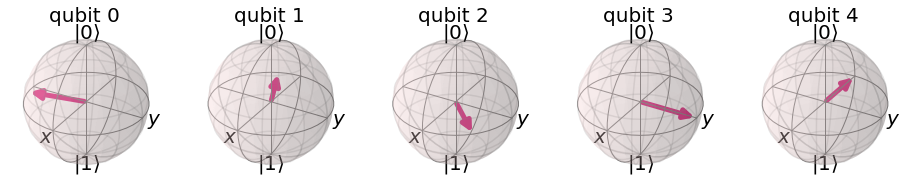

In [218]:
"""Statevector of 25 in fourier basis"""
backend = Aer.get_backend("statevector_simulator")
statevector = execute(circ, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

## Testing on a simulator

In [221]:
# To obtain a distinguishable result, we will have to convert the state back into the computational basis state so that we can
# measure a binary output. To do that, we'll have to apply the inverse of the QFT function. This will be easy since qiskit has
# an in-built function to invert a given circuit/gate

def inverse_qft(circ, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we need to make a normal QFT circuit using our function:
    qft_circuit = qft_full(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circuit = qft_circuit.inverse()
    # And add it to the first n qubits in our existing circuit
    circ.append(invqft_circuit, circ.qubits[:n])
    return circ.decompose() # .decompose() allows us to see the individual gates

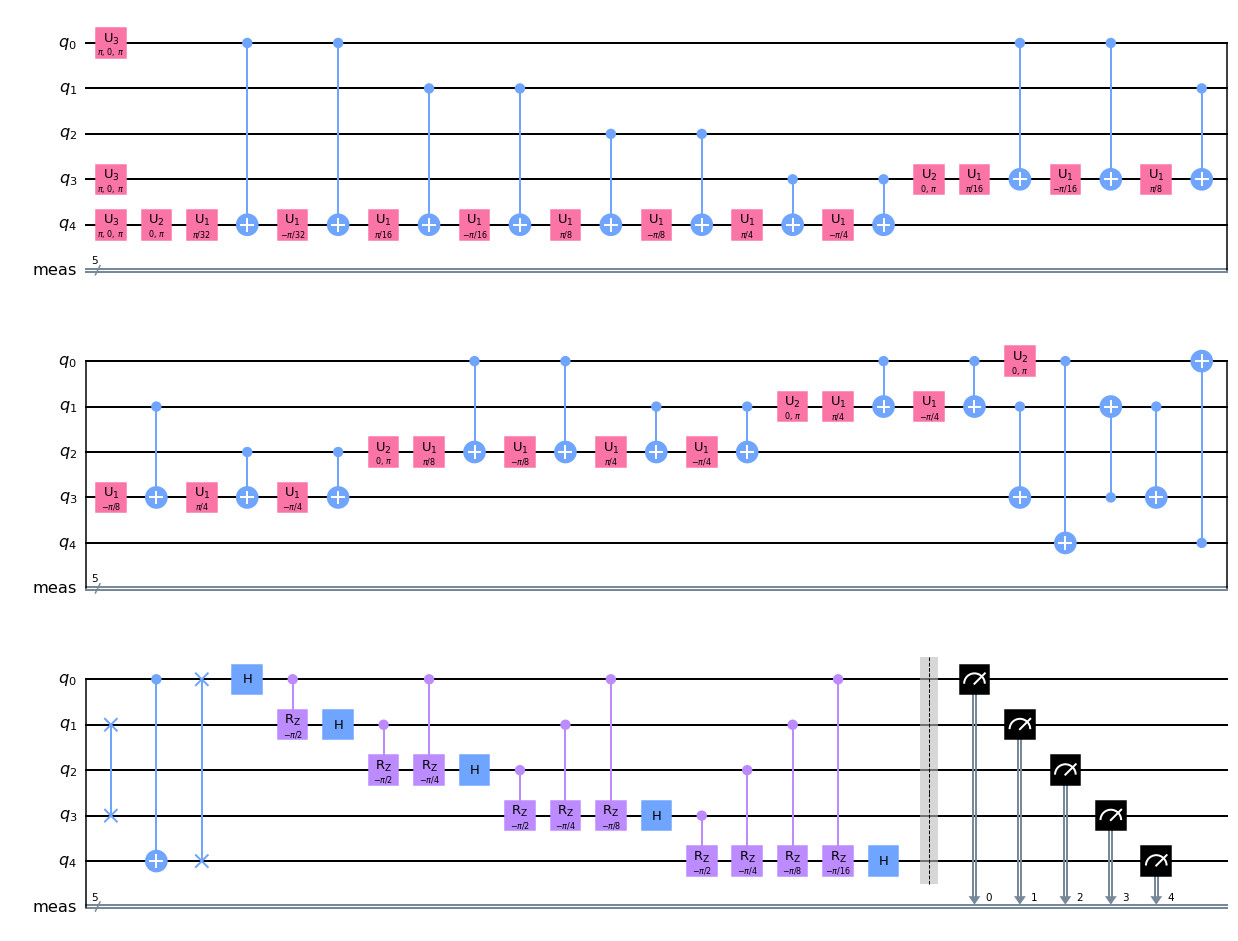

In [222]:
circ = inverse_qft(circ,5)
circ.measure_all()
circ.draw('mpl')

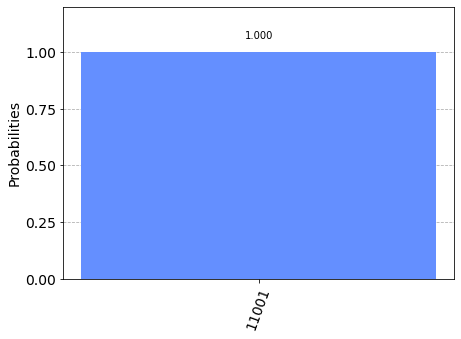

In [224]:
backend = Aer.get_backend('qasm_simulator')
results = execute(circ, backend=backend, shots=1024).result()
counts = results.get_counts()
plot_histogram(counts)

As you can see above, the circuit outputs the state 11001 which was our input 25! Now, we will try it on an actual quantum computer but I predict the results to be bogus since this circuit will be prone to a lot of decoherence, thereby making the result useless. You've gotta love the NISQ age! 😄

In [240]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 5 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2020-12-24 23:58:07,901: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmqx2


In [241]:
job = execute(circ, backend=backend, shots=1024)
results = job.result()
job_monitor(job)

Job Status: job has successfully run


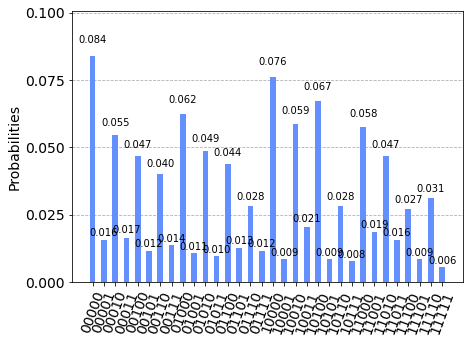

In [242]:
counts = job.result().get_counts()
plot_histogram(counts)

As we might've expected, the same circuit run on an actual quantum computer has given us completely insignificant results. This brings to light the importance of overcoming decoherence if we want to improve our hardware.

# References
1. M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).